 In this Release we chqnge the following:
 - encoder-decoder architecture + VAE; 


In [510]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Concatenate
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
import pickle


def create_lstm_vae(input_dim_pitch, input_dim_rythm,
    prime_dim_pitch, prime_dim_rythm,                
    timesteps, 
    batch_size, 
    intermediate_dim_pitch, intermediate_dim_rythm,
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x_pitch = Input(shape=(timesteps, input_dim_pitch,), name = "pitch_input")
    x_rythm = Input(shape=(timesteps, input_dim_rythm,), name = "rythm_input")

    # LSTM encoding
    h_pitch = LSTM(intermediate_dim_pitch)(x_pitch)
    h_rythm = LSTM(intermediate_dim_rythm)(x_rythm)

    h = Concatenate(axis = -1)([h_pitch, h_rythm])
    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)

    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
            mean=0., stddev=epsilon_std)
        
        print(z_log_sigma.shape)
        print(epsilon.shape)
        return z_mean + z_log_sigma * epsilon
    


    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    
    # decoded LSTM layer
    decoder_h_pitch = LSTM(intermediate_dim_pitch, return_sequences=True)
    decoder_mean_pitch = LSTM(prime_dim_pitch, return_sequences=True)
    soft_pitch = Dense(input_dim_pitch, name = "pitch", activation='softmax')
    
    decoder_h_rythm = LSTM(intermediate_dim_rythm, return_sequences=True)
    decoder_mean_rythm = LSTM(prime_dim_rythm, return_sequences=True)
    soft_rythm = Dense(input_dim_rythm, name = "rythm", activation='softmax')
    
    h_decoded_pitch = RepeatVector(timesteps)(z)
    h_decoded_pitch = decoder_h_pitch(h_decoded_pitch)
    
    h_decoded_rythm = RepeatVector(timesteps)(z)
    h_decoded_rythm = decoder_h_rythm(h_decoded_rythm)

    # decoded layer
    x_decoded_mean_pitch = soft_pitch(decoder_mean_pitch(h_decoded_pitch))
    
    x_decoded_mean_rythm = soft_rythm(decoder_mean_rythm(h_decoded_rythm))
    
    # end-to-end autoencoder
    vae = Model([x_pitch, x_rythm], [x_decoded_mean_pitch, x_decoded_mean_rythm])
    # encoder, from inputs to latent space
    
    encoder_pitch = Model([x_pitch, x_rythm], z_mean)
    encoder_rythm = Model([x_pitch, x_rythm], z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input_pitch = Input(shape=(latent_dim,))
    decoder_input_rythm = Input(shape=(latent_dim,))

    _h_decoded_pitch = RepeatVector(timesteps)(decoder_input_pitch)
    _h_decoded_pitch = decoder_h_pitch(_h_decoded_pitch)
    
    _h_decoded_rythm = RepeatVector(timesteps)(decoder_input_rythm)
    _h_decoded_rythm = decoder_h_rythm(_h_decoded_rythm)

    
    _x_decoded_mean_pitch = soft_pitch(decoder_mean_pitch(_h_decoded_pitch))
    generator_pitch = Model(decoder_input_pitch, _x_decoded_mean_pitch)
    
    _x_decoded_mean_rythm = soft_rythm(decoder_mean_rythm(_h_decoded_rythm))
    generator_rythm = Model(decoder_input_rythm, _x_decoded_mean_rythm)
    
    def vae_loss_pitch(x, x_decoded_mean):
        xent_loss = objectives.categorical_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss
    
    def vae_loss_rythm(x, x_decoded_mean):
        loss = objectives.categorical_crossentropy(x, x_decoded_mean)
        print(x.shape, x_decoded_mean.shape)
        return loss
    encoder_pitch = Model([x_pitch, x_rythm], z_mean)
    vae.compile(optimizer='adam', loss={"pitch":vae_loss_pitch, "rythm":vae_loss_rythm})
    
    return vae, encoder_pitch, encoder_rythm, generator_pitch, generator_rythm

In [511]:
vae, encoder_pitch, encoder_rythm, generator_pitch, generator_rythm = create_lstm_vae(
    input_dim_pitch = 47, input_dim_rythm = 5,
    prime_dim_pitch = 50, prime_dim_rythm = 50,
    timesteps = 10, 
    batch_size = 100, 
    intermediate_dim_pitch = 100, intermediate_dim_rythm = 100,
    latent_dim = 100)

(?, 100)
(100, 100)
(?, ?, ?) (?, 10, 5)


In [512]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pitch_input (InputLayer)        (None, 10, 47)       0                                            
__________________________________________________________________________________________________
rythm_input (InputLayer)        (None, 10, 5)        0                                            
__________________________________________________________________________________________________
lstm_128 (LSTM)                 (None, 100)          59200       pitch_input[0][0]                
__________________________________________________________________________________________________
lstm_129 (LSTM)                 (None, 100)          42400       rythm_input[0][0]                
__________________________________________________________________________________________________
concatenat

In [517]:
vae.fit({"pitch_input":X_pitch_np, "rythm_input":X_rythm_np}, {"pitch":X_pitch_np, "rythm":X_rythm_np}, shuffle = True, batch_size = 100, epochs = 1)

Epoch 1/1
773500/773533 [============================>.] - ETA: 0s - loss: 0.2485 - pitch_loss: 0.2268 - rythm_loss: 0.0217

InvalidArgumentError: Incompatible shapes: [33,100] vs. [100,100]
	 [[Node: lambda_27/mul = Mul[T=DT_FLOAT, _class=["loc:@training_18/Adam/gradients/lambda_27/mul_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_54/BiasAdd, lambda_27/random_normal)]]
	 [[Node: loss_22/add/_5583 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7199_loss_22/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'lambda_27/mul', defined at:
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-511-c0718deafdea>", line 7, in <module>
    latent_dim = 100)
  File "<ipython-input-510-55bec2b79f64>", line 58, in create_lstm_vae
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\keras\layers\core.py", line 685, in call
    return self.function(inputs, **arguments)
  File "<ipython-input-510-55bec2b79f64>", line 52, in sampling
    return z_mean + z_log_sigma * epsilon
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\ops\math_ops.py", line 979, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1211, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 5066, in mul
    "Mul", x=x, y=y, name=name)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [33,100] vs. [100,100]
	 [[Node: lambda_27/mul = Mul[T=DT_FLOAT, _class=["loc:@training_18/Adam/gradients/lambda_27/mul_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_54/BiasAdd, lambda_27/random_normal)]]
	 [[Node: loss_22/add/_5583 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7199_loss_22/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [23]:
vae.predict([X_pitch_np, X_rythm_np])

InvalidArgumentError: Incompatible shapes: [32,87] vs. [100,87]
	 [[Node: lambda_6/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_12/BiasAdd, lambda_6/random_normal)]]
	 [[Node: pitch_5/transpose_1/_709 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1275_pitch_5/transpose_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'lambda_6/mul', defined at:
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-ad2ae365328d>", line 6, in <module>
    latent_dim = 87)
  File "<ipython-input-20-9dee9869d878>", line 57, in create_lstm_vae
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\keras\layers\core.py", line 685, in call
    return self.function(inputs, **arguments)
  File "<ipython-input-20-9dee9869d878>", line 51, in sampling
    return z_mean + z_log_sigma * epsilon
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\ops\math_ops.py", line 979, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1211, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 5066, in mul
    "Mul", x=x, y=y, name=name)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [32,87] vs. [100,87]
	 [[Node: lambda_6/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_12/BiasAdd, lambda_6/random_normal)]]
	 [[Node: pitch_5/transpose_1/_709 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1275_pitch_5/transpose_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [513]:
from keras.utils import np_utils
import numpy as np

rythm_X = pickle.load(open( "jazz_rythm.txt", "rb" ), encoding = 'bytes')
pitch_X = pickle.load(open( "jazz_pitch.txt", "rb" ), encoding = 'bytes')

non_trainable_first = 10

Tx = non_trainable_first
pitch_output_shape = 47
rythm_output_shape = 5

X_pitch = []
X_rythm = []

y_pitch = []
y_rythm = []

encode_lengths = {1:0, 2:1, 4:2, 8:3, 16:4}

def enc_l(arr):
    return [encode_lengths[x] for x in arr]

for pitch_s, rythm_s in zip(pitch_X, rythm_X):
    '''
    lgth = (len(pitch_s) - 1) // Tx
    for i in range(lgth):
        
        
        X_pitch.append(np_utils.to_categorical(pitch_s[i * Tx: (i + 1) * Tx],pitch_output_shape ))
        #y_pitch.append(np_utils.to_categorical(pitch_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1],pitch_output_shape))
        
        X_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i * Tx: (i + 1) * Tx]),rythm_output_shape))
        #y_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1]),rythm_output_shape))
    
    '''
    if len(pitch_s) < 24:
        continue
    lgth = (len(pitch_s) - 24)
    
    for i in range(lgth):
        X_pitch.append(np_utils.to_categorical(pitch_s[i : i + 10], pitch_output_shape ))
        y_pitch.append(np_utils.to_categorical(pitch_s[i + 10: i + 20],pitch_output_shape))
        
        X_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i : i + 10]),rythm_output_shape))
        y_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i + 10: i + 20]),rythm_output_shape))
    
#Y_pitch = [list(y_pitch[i]) for i in range(len(y_pitch))]#
#print(y_pitch[0])
#Y_pitch = np.array([y[0] for y in Y_pitch])#[:100000]

#Y_rythm = [list(y_rythm[i]) for i in range(len(y_rythm))]#
#Y_rythm = np.array([y[0] for y in Y_rythm])#[:100000]


X_pitch_np = np.array(X_pitch)#[:100000]#[x for x in X_pitch]
X_rythm_np = np.array(X_rythm)#[:100000]


(100000, 10, 25)

In [345]:
def create_track_new(seq, seq_pitch):
    
    #num_to_len = {1:1, 2:2, 3:4, 4:8, 5:16, 6:32}
    grain = 32
    one_tact = 128
    tacts_per_min = 75
    tempo    = one_tact * tacts_per_min  # In BPM
    volume   = 100  # 0-127, as per the MIDI standard
    track    = 0
    channel  = 0
    time     = 0# to learn
    
    MyMIDI = MIDIFile(1)
    MyMIDI.addTempo(track, time, tempo)
    
    MyMIDI.addNote(track, channel, 120, 0, one_tact / grain, volume)
    tick_count = one_tact / grain
    
    current_pitch = 80
    
    tick_counts = [tick_count]
    pitches = [current_pitch]
    
    decode_lengths  = {0:1, 1:2, 2:4, 3:8, 4:16}
    for l,p in zip(seq, seq_pitch):
        current_pitch += (p - 23)
        if current_pitch < 20:
            current_pitch += 50
        if current_pitch > 100:
            current_pitch -= 50
        pitches += [current_pitch]
        #length = num_to_len[l]
        MyMIDI.addNote(track, channel, current_pitch, tick_count, one_tact / grain * (decode_lengths[l]), volume)
        tick_count = tick_count + one_tact / grain * (decode_lengths[l])
        tick_counts += [tick_count]
    
    plt.scatter(tick_counts, pitches, s = 1)
    plt.show()
    print(track)

    with open("zzz.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file) 
                
                            
                    


In [373]:
np.random.rand(1)

array([0.92225385])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 4, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 4, 4, 4, 2, 3, 2, 2, 2, 2, 2, 0, 3, 3, 2, 3, 2, 2, 2, 2, 2, 0, 3, 3, 2, 0, 2, 1, 0, 3, 0, 0, 3, 3, 4, 4, 4, 0, 0, 1, 4, 1, 4, 4, 4, 1, 1, 4, 1, 3, 4, 1, 4, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1

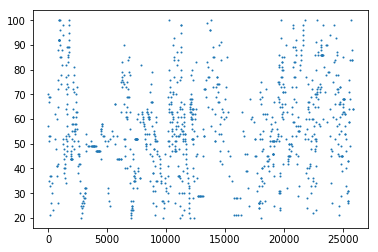

0


In [520]:
z =  np.random.multivariate_normal(np.zeros(100), np.identity(100), 1 )

generated_rythms = []
generated_pitches = []
alpha = 0.1

for t in range(100):
    alpha= np.random.rand(1)[0]
    print(t)
    
    pred_rythm = generator_rythm.predict(z)
    pred_pitch = generator_pitch.predict(z)

    
    gen_r = [take_one(x) for x in [pred_rythm[0, i, :] for i in range(pred_rythm.shape[1])] ]
    gen_p = [take_one(x) for x in [pred_pitch[0, i, :] for i in range(pred_pitch.shape[1])]]
    
    generated_rythms += gen_r
    generated_pitches += gen_p
    

    generated_pitches_vec = np.array([[np_utils.to_categorical(x, 47 ) for x in gen_p]])
    generated_rythms_vec = np.array([[np_utils.to_categorical(x, 5 ) for x in gen_r]])
    
    z = ( (1 - alpha) * encoder_rythm.predict([generated_pitches_vec, generated_rythms_vec])
         + alpha * np.random.multivariate_normal(np.zeros(100), np.identity(100), 1))
print(generated_rythms)
print(generated_pitches)
create_track_new(generated_rythms, generated_pitches)

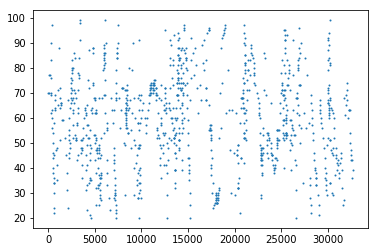

0


In [506]:
create_track_new(generated_rythms, generated_pitches)

In [491]:
z = np.random.multivariate_normal(np.zeros(100), np.identity(100), 1 )

pred_rythm = generator_rythm.predict(z)
pred_pitch = generator_pitch.predict(z)

In [496]:
from midiutil import MIDIFile
def create_track_new(seq, seq_pitch):
    
    #num_to_len = {1:1, 2:2, 3:4, 4:8, 5:16, 6:32}
    grain = 16
    one_tact = 128
    tacts_per_min = 75
    tempo    = one_tact * tacts_per_min  # In BPM
    volume   = 100  # 0-127, as per the MIDI standard
    track    = 0
    channel  = 0
    time     = 0# to learn
    
    MyMIDI = MIDIFile(1)
    MyMIDI.addTempo(track, time, tempo)
    
    MyMIDI.addNote(track, channel, 120, 0, one_tact / grain, volume)
    tick_count = one_tact / grain
    
    current_pitch = 70
    
    tick_counts = [tick_count]
    pitches = [current_pitch]
    
    decode_lengths  = {0:1, 1:2, 2:4, 3:8, 4:16}
    for l,p in zip(seq, seq_pitch):
        current_pitch += (p - 23)
        if current_pitch < 20:
            current_pitch += 50
        if current_pitch > 100:
            current_pitch -= 50
        pitches += [current_pitch]
        #length = num_to_len[l]
        MyMIDI.addNote(track, channel, current_pitch, tick_count, one_tact / grain * (decode_lengths[l]), volume)
        tick_count = tick_count + one_tact / grain * (decode_lengths[l])
        tick_counts += [tick_count]
    
    plt.scatter(tick_counts, pitches, s = 1)
    plt.show()
    print(track)

    with open("zzz.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file) 
                
                            
                    



0
(1, 10, 5)
1
(1, 10, 5)
2
(1, 10, 5)
3
(1, 10, 5)
4
(1, 10, 5)
5
(1, 10, 5)
6
(1, 10, 5)
7
(1, 10, 5)
8
(1, 10, 5)
9
(1, 10, 5)
[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[7, 5, 0, 24, 4, 19, 13, 3, 9, 24, 7, 5, 0, 24, 4, 13, 13, 21, 9, 24, 7, 5, 3, 24, 4, 13, 13, 15, 6, 24, 7, 5, 3, 24, 4, 13, 13, 13, 6, 24, 7, 5, 3, 4, 4, 13, 13, 13, 6, 24, 7, 5, 3, 4, 4, 13, 13, 13, 6, 24, 7, 5, 3, 4, 4, 13, 13, 13, 6, 24, 7, 5, 3, 4, 4, 13, 13, 16, 6, 24, 7, 5, 3, 4, 4, 13, 13, 16, 6, 24, 7, 5, 3, 4, 4, 13, 13, 16, 6, 24]


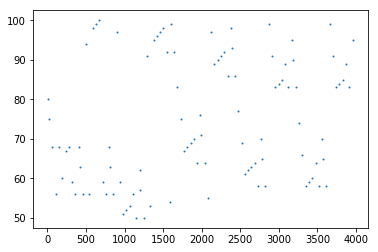

0


In [330]:
z = np.random.multivariate_normal(np.zeros(100), np.identity(100), 1 )

generated_rythms = []
generated_pitches = []
for t in range(10):
    print(t)
    
    pred_rythm = generator_rythm.predict(z)
    pred_pitch = generator_pitch.predict(z)
    print(pred_rythm.shape)
    gen_r = [take_one(x) for x in [pred_rythm[0][i] for i in range(pred_rythm.shape[1])] ]
    gen_p = [take_one(x) for x in [pred_pitch[0][i] for i in range(pred_pitch.shape[1])]]
    
    generated_rythms += gen_r
    generated_pitches += gen_p
    

    generated_pitches_vec = np.array([[np_utils.to_categorical(x, 25 ) for x in gen_p]])
    generated_rythms_vec = np.array([[np_utils.to_categorical(x, 5 ) for x in gen_r]])
    
    z = encoder_rythm.predict([generated_pitches_vec, generated_rythms_vec])

print(generated_rythms)
print(generated_pitches)
create_track_new(generated_rythms, generated_pitches)

In [161]:
import matplotlib.pyplot as plt

In [111]:
pred_rythm = generator_rythm.predict(z)
[pred_rythm[0][i] for i in range(pred_rythm.shape[1])]

[array([ 0.7611949,  0.       ,  0.       ,  0.0284371, -0.       ],
       dtype=float32),
 array([-0.05047647,  0.        ,  0.        ,  0.69215477, -0.        ],
       dtype=float32),
 array([-0.       ,  0.       ,  0.       ,  0.9950524, -0.       ],
       dtype=float32),
 array([-0.        ,  0.        ,  0.        ,  0.99932885, -0.        ],
       dtype=float32),
 array([-0.       ,  0.       ,  0.       ,  0.9999091, -0.       ],
       dtype=float32),
 array([-0.       ,  0.       ,  0.       ,  0.9999877, -0.       ],
       dtype=float32),
 array([-0.        ,  0.        ,  0.        ,  0.99999833, -0.        ],
       dtype=float32),
 array([-0.        ,  0.        ,  0.        ,  0.99999976, -0.        ],
       dtype=float32),
 array([-0.        ,  0.        ,  0.        ,  0.99999994, -0.        ],
       dtype=float32),
 array([-0.,  0.,  0.,  1., -0.], dtype=float32)]

In [305]:
def take_one(pred):
    #print(pred.shape)
    a = np.log(pred) / 1.0 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a))
    return np.random.choice(choices, p=dist)

In [89]:
s = 0
for i in range(100):
    s += take_one(np.array([[0.5, 0.25, 0.25]])) % 2

In [90]:
s

22

In [56]:
generated_pitches = generator_pitch.predict(np.random.multivariate_normal(np.zeros(100), np.identity(100), 100 ))
np.argmax(generated_pitches, axis = -1)

array([[17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [19,  6, 18, 18, 18, 18, 18, 18, 18, 18],
       [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
       [ 8,  8,  0,  8,  8,  8,  8,  8,  8,  8],
       [ 0, 16, 16,  0,  0,  0,  0,  3,  0,  3],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [10, 18, 21, 18, 24, 24, 24, 14, 14, 14],
       [16, 16, 16, 16, 12, 12, 12, 12, 12, 12],
       [ 8,  0,  8,  8,  8,  8,  8,  8,  8,  8],
       [11,  0,  0,  0, 17, 17, 17, 17, 17, 17],
       [11, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [ 5,  3, 15,  3, 15, 14, 14, 14, 14, 14],
       [11, 11, 11,  0,  0,  0,  0,  0,  0,  0],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
       [10, 10, 13, 13, 13, 13, 13, 13, 13, 13],
       [12, 24,  5, 24,  9,  9,  9,  9,  4,  4],
       [ 7,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [ 8, 11, 17, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 

In [53]:
np.argmax(generated_pitches, axis = -1)

array([[14,  9, 17, 17, 17,  9,  9,  9,  9,  9],
       [11, 17, 11, 14, 12, 12, 12, 12, 12, 14]], dtype=int64)

In [ ]:
    y = Lambda(lambda x: K.mean(-0.5 * K.mean(1 + x[1] - K.square(x[0]) - K.exp(x[1]), axis=-1)))
    y = y([z_mean, z_log_var])
    out_z.append(y)
    

In [48]:


from keras.losses import categorical_crossentropy#(y_true, y_pred)
from keras import backend as K

     

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)#lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01

model.compile(optimizer=opt, loss={'pitch':categorical_crossentropy, 'rythm':vae_lossvae_loss}, metrics=['accuracy'])

In [28]:
import pickle
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

rythm_X = pickle.load(open( "jazz_rythm.txt", "rb" ), encoding = 'bytes')
pitch_X = pickle.load(open( "jazz_pitch.txt", "rb" ), encoding = 'bytes')

non_trainable_first = setting.non_trainable_first
Tx = setting.Tx

pitch_output_shape = setting.pitch_output_shape
rythm_output_shape = setting.rythm_output_shape

X_pitch = []
X_rythm = []

y_pitch = []
y_rythm = []

encode_lengths = {1:0, 2:1, 4:2, 8:3, 16:4}

def enc_l(arr):
    return [encode_lengths[x] for x in arr]

for pitch_s, rythm_s in zip(pitch_X, rythm_X):
    '''
    lgth = (len(pitch_s) - 1) // Tx
    for i in range(lgth):
        
        
        X_pitch.append(np_utils.to_categorical(pitch_s[i * Tx: (i + 1) * Tx],pitch_output_shape ))
        y_pitch.append(np_utils.to_categorical(pitch_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1],pitch_output_shape))
        
        X_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i * Tx: (i + 1) * Tx]),rythm_output_shape))
        y_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1]),rythm_output_shape))
    '''
    if len(pitch_s) < 24:
        continue
    lgth = (len(pitch_s) - 24)
    
    for i in range(lgth):
        X_pitch.append(np_utils.to_categorical(pitch_s[i : i + 10], pitch_output_shape ))
        y_pitch.append(np_utils.to_categorical(pitch_s[i + 10: i + 20],pitch_output_shape))
        
        X_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i : i + 10]),rythm_output_shape))
        y_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i + 10: i + 20]),rythm_output_shape))
        
Y_pitch = [list(y_pitch[i]) for i in range(len(y_pitch))]#
Y_pitch = np.array([y[0] for y in Y_pitch[:100000]])

Y_rythm = [list(y_rythm[i]) for i in range(len(y_rythm))]#
Y_rythm = np.array([y[0] for y in Y_rythm[:100000]])


X_pitch_np = np.array(X_pitch)[:100000]#[x for x in X_pitch]
X_rythm_np = np.array(X_rythm)[:100000]



m = X_pitch_np.shape[0]

manager_internal_shape = setting.manager_internal_shape
pitch_internal_shape = setting.pitch_internal_shape
rythm_internal_shape = setting.rythm_internal_shape

pitch_state_0 = np.zeros((m, pitch_internal_shape))
rythm_state_0 = np.zeros((m, rythm_internal_shape))
manager_state_0 = np.zeros((m, manager_internal_shape))



model.fit([X_pitch_np, X_rythm_np,  pitch_state_0, rythm_state_0, manager_state_0],\
          {'inter_to_pitch':Y_pitch, 'inter_to_rythm':Y_rythm}, batch_size = 100, epochs=3, verbose = 1, shuffle = True)


Epoch 1/3
100000/100000 [==============================] - 250s 3ms/step - loss: 0.4639 - inter_to_pitch_loss: 0.1582 - inter_to_rythm_loss: 0.3057 - inter_to_pitch_acc: 0.2639 - inter_to_rythm_acc: 0.4739
Epoch 2/3
100000/100000 [==============================] - 241s 2ms/step - loss: 0.4620 - inter_to_pitch_loss: 0.1573 - inter_to_rythm_loss: 0.3046 - inter_to_pitch_acc: 0.2641 - inter_to_rythm_acc: 0.4743
Epoch 3/3
100000/100000 [==============================] - 241s 2ms/step - loss: 0.4618 - inter_to_pitch_loss: 0.1573 - inter_to_rythm_loss: 0.3046 - inter_to_pitch_acc: 0.2641 - inter_to_rythm_acc: 0.4743


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_pitch (InputLayer)            (None, 10, 25)       0                                            
__________________________________________________________________________________________________
X_rythm (InputLayer)            (None, 10, 5)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 25, 1)        0           X_pitch[0][0]                    
__________________________________________________________________________________________________
pitch_state_0 (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_2 (

In [102]:
element = 1000

Y_pitch = [list(y_pitch[i]) for i in range(len(y_pitch))]#
Y_pitch = np.array([y[0] for y in Y_pitch[element]])

Y_rythm = [list(y_rythm[i]) for i in range(len(y_rythm))]#
Y_rythm = np.array([y[0] for y in Y_rythm[element]])


X_pitch_np = np.array(X_pitch)[element:element + 1]#[x for x in X_pitch]
X_rythm_np = np.array(X_rythm)[element:element + 1]


m = X_pitch_np.shape[0]

manager_internal_shape = setting.manager_internal_shape
pitch_internal_shape = setting.pitch_internal_shape
rythm_internal_shape = setting.rythm_internal_shape

pitch_state_0 = np.zeros((m, pitch_internal_shape))
rythm_state_0 = np.zeros((m, rythm_internal_shape))
manager_state_0 = np.zeros((m, manager_internal_shape))

layer_name = 'pitch_gru'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).get_output_at(0))
intermediate_layer_model.predict([X_pitch_np, X_rythm_np,  pitch_state_0, rythm_state_0, manager_state_0])

array([[-0.00303974,  0.01886736,  0.00392841, -0.01842227,  0.00013647,
        -0.00563659, -0.01032083,  0.00584648, -0.00346822,  0.0241624 ,
         0.00054345, -0.00762069, -0.02385939, -0.00364046, -0.00440928,
         0.00369517,  0.00283302,  0.01686856,  0.00075944,  0.00324114,
        -0.00750755,  0.0016992 ,  0.00205383, -0.00329115,  0.00167905,
        -0.00539649,  0.00516429,  0.00055218,  0.00847614,  0.00336826,
        -0.00218078,  0.00959649, -0.00207382,  0.00411171,  0.00456343,
        -0.00243597, -0.00496944, -0.01918453, -0.00143453, -0.00519804,
        -0.00333782,  0.00389768,  0.00318724, -0.00197877, -0.00155421,
         0.0232743 , -0.01861566,  0.00743173, -0.00796284,  0.00015538,
         0.00155061,  0.00525048, -0.01116654, -0.00073952, -0.01000661,
        -0.0152561 , -0.0030193 ,  0.00052883,  0.02785456, -0.00092636,
         0.00263312,  0.00427835,  0.00212559,  0.00173554, -0.02528634,
         0.02076484,  0.00462911,  0.00630576,  0.0

In [101]:
element = 2345

Y_pitch = [list(y_pitch[i]) for i in range(len(y_pitch))]#
Y_pitch = np.array([y[0] for y in Y_pitch[element]])

Y_rythm = [list(y_rythm[i]) for i in range(len(y_rythm))]#
Y_rythm = np.array([y[0] for y in Y_rythm[element]])


X_pitch_np = np.array(X_pitch)[element:element + 1]#[x for x in X_pitch]
X_rythm_np = np.array(X_rythm)[element:element + 1]


m = X_pitch_np.shape[0]

manager_internal_shape = setting.manager_internal_shape
pitch_internal_shape = setting.pitch_internal_shape
rythm_internal_shape = setting.rythm_internal_shape

pitch_state_0 = np.zeros((m, pitch_internal_shape))
rythm_state_0 = np.zeros((m, rythm_internal_shape))
manager_state_0 = np.zeros((m, manager_internal_shape))

layer_name = 'pitch_gru'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).get_output_at(0))
intermediate_layer_model.predict([X_pitch_np, X_rythm_np,  pitch_state_0, rythm_state_0, manager_state_0])

array([[-0.00361132,  0.01873892,  0.00460489, -0.0188433 , -0.00026344,
        -0.00626706, -0.01000399,  0.00605333, -0.00357501,  0.02389743,
         0.00056244, -0.00812239, -0.02412687, -0.00366494, -0.00474457,
         0.00424624,  0.00304369,  0.01643826,  0.00083183,  0.00274095,
        -0.00750325,  0.00175363,  0.0017711 , -0.00265339,  0.0018587 ,
        -0.0050061 ,  0.006204  ,  0.00074088,  0.00894731,  0.00335177,
        -0.00177686,  0.00921258, -0.00203514,  0.00452002,  0.00534161,
        -0.0025859 , -0.00480505, -0.01841985, -0.00212035, -0.00461425,
        -0.00311361,  0.00426954,  0.00272169, -0.00230937, -0.0018312 ,
         0.02289029, -0.01818012,  0.00767828, -0.00764846,  0.00080984,
         0.00122366,  0.00527267, -0.01103281, -0.00069241, -0.0103082 ,
        -0.01592911, -0.00265925,  0.00059422,  0.02734835, -0.00045626,
         0.00272808,  0.0045769 ,  0.00127139,  0.00160058, -0.02557486,
         0.02080528,  0.00524872,  0.00623439,  0.0

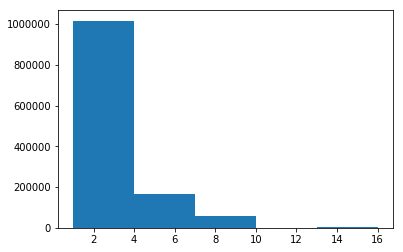

In [82]:
h = plt.hist(reduce(lambda x,y:x+y,rythm_X), bins = 5)

In [83]:
h[0] / np.sum(h[0])

array([0.81278173, 0.1345765 , 0.04761897, 0.        , 0.00502279])

In [44]:

model.get_output_at(0)

[<tf.Tensor 'dense_35/Softmax:0' shape=(?, 25) dtype=float32>,
 <tf.Tensor 'dense_36/Softmax:0' shape=(?, 5) dtype=float32>]

In [78]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_pitch (InputLayer)            (None, 10, 25)       0                                            
__________________________________________________________________________________________________
X_rythm (InputLayer)            (None, 10, 5)        0                                            
__________________________________________________________________________________________________
lambda_741 (Lambda)             (None, 25, 1)        0           X_pitch[0][0]                    
__________________________________________________________________________________________________
pitch_state_0 (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_742

In [25]:
h = np.array(np.log2(np.array(reduce(lambda x,y:x+y,rythm_X))) , dtype = 'int32')

In [26]:
set(h)

{0, 1, 2, 3, 4}

In [18]:
set(h)

{1, 2, 4, 8, 16}

In [19]:
np.log(1)

0.0

In [ ]:
rythm_X[0]

In [ ]:
#Y = [[y_pitch[i], y_rythm[i]] for i in range(len(y_pitch))] 
np.array([len(y) for y in y_pitch])[np.array([len(y) for y in y_pitch]) != 1]

In [ ]:
Y[0][0].shape

In [ ]:
np.min(X_pitch_np[0],axis = 1)

In [ ]:
len(X_pitch)

In [ ]:
model.summ

In [ ]:
X_pitch, X_rythm, pitch_state_0, rythm_state_0, manager_state_0

In [ ]:
model.summary()

In [24]:
def make_prediction(setting, to_generate):

    X_pitch = Input(shape = (setting.Tx, setting.pitch_output_shape), name = 'X_pitch')
    X_rythm = Input(shape = (setting.Tx, setting.rythm_output_shape), name = 'X_rythm')
    
    reshapor_pitch = Reshape((setting.pitch_output_shape, 1))#?
    reshapor_rythm = Reshape((setting.rythm_output_shape, 1))
    
    manager_state_0 = Input(shape=(setting.manager_internal_shape, ), name = 'manager_state_0')
    pitch_state_0 = Input(shape = (setting.pitch_internal_shape, ), name = 'pitch_state_0')
    rythm_state_0 = Input(shape = (setting.rythm_internal_shape, ), name = 'rythm_state_0')

    manager_state = manager_state_0
    pitch_state = pitch_state_0
    rythm_state = rythm_state_0
    
    reshapor_pitch = Reshape((setting.pitch_output_shape, 1))
    reshapor_rhythm = Reshape((setting.rythm_output_shape, 1))
    
    reshapor_concat = Reshape((setting.pitch_to_manager_shape + setting.rythm_to_manager_shape, 1))
    

    out_pitches = []
    out_rythms = []


    for t in range(non_trainable_first):
        #print(t)

        get_pitch_t =  Lambda(lambda x: reshapor_pitch(x[:, t, :])) 
        get_rythm_t = Lambda(lambda x: reshapor_rythm(x[:, t, :]))  

        pitch_state = setting.pitch_gru(get_pitch_t(X_pitch), initial_state = [pitch_state])
        rythm_state = setting.rythm_gru(get_rythm_t(X_rythm), initial_state = [rythm_state])
        
        
        concat = reshapor_concat(Concatenate(axis = 1)([setting.pitch_to_manager(pitch_state),\
                                                        setting.rythm_to_manager(rythm_state)]))
        
        manager_state = setting.manager_gru(concat, initial_state = [manager_state])
    
        output_pitch = setting.inter_to_pitch(setting.manager_to_inter_pitch(manager_state))
        output_rythm = setting.inter_to_rythm(setting.manager_to_inter_rythm(manager_state))
        

    

    for t in range(to_generate):
        #print(t)
        
        #Sample pitch
        #pitch = Lambda(lambda x: tf.one_hot(tf.multinomial(x, 1), pitch_output_shape))#np.random.choice(pitch_output_shape, output_pitch)
        pitch = Lambda(lambda x: tf.one_hot(tf.argmax(x, axis = 1), pitch_output_shape))

        
        #Sample rythm        
        #rythm = Lambda(lambda x: tf.one_hot(tf.multinomial(x, 1), rythm_output_shape))
        rythm = Lambda(lambda x: tf.one_hot(tf.argmax(x, axis = 1), rythm_output_shape))
        
        pitch_sampled = reshapor_pitch(pitch(output_pitch))
        rythm_sampled = reshapor_rythm(rythm(output_rythm))
        
        #print(pitch_sampled)
        out_pitches.append(pitch_sampled)
        out_rythms.append(rythm_sampled)
        #####################################
        
        pitch_state = setting.pitch_gru(pitch_sampled, initial_state = [pitch_state])
        rythm_state = setting.rythm_gru(rythm_sampled, initial_state = [rythm_state])
        
        concat = reshapor_concat(Concatenate(axis = 1)([setting.pitch_to_manager(pitch_state),\
                                                setting.rythm_to_manager(rythm_state)]))
        
        manager_state = setting.manager_gru(concat, initial_state = [manager_state])
        
        
        output_pitch = setting.inter_to_pitch(setting.manager_to_inter_pitch(manager_state))
        output_rythm = setting.inter_to_rythm(setting.manager_to_inter_rythm(manager_state))
        

        

    out = out_pitches + out_rythms

    model_general = Model(inputs = [X_pitch, X_rythm, pitch_state_0, rythm_state_0, manager_state_0], outputs = out)

    return model_general

In [25]:
number_of_notes_to_generate = 100
model_predict = make_prediction(setting, number_of_notes_to_generate)

In [26]:
#m = X_pitch_np.shape[0]

manager_internal_shape = setting.manager_internal_shape
pitch_internal_shape = setting.pitch_internal_shape
rythm_internal_shape = setting.rythm_internal_shape

pitch_state_0 = np.zeros((1, pitch_internal_shape))
rythm_state_0 = np.zeros((1, rythm_internal_shape))
manager_state_0 = np.zeros((1, manager_internal_shape))

X_pitch_np = np.array(X_pitch)[1000,:setting.Tx].reshape((1,setting.Tx,setting.pitch_output_shape))
X_rythm_np = np.array(X_rythm)[1000,:setting.Tx].reshape((1,setting.Tx,setting.rythm_output_shape))
#X_pitch_np = [np.argmax(x) for x in X_pitch_np]
#X_rythm_np = [np.argmax(x) for x in X_rythm_np]

result = model_predict.predict([X_pitch_np, X_rythm_np,  pitch_state_0, rythm_state_0, manager_state_0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


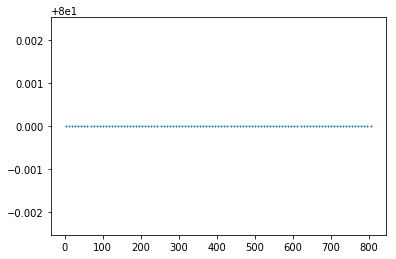

0


In [27]:

seq_p = result[:number_of_notes_to_generate]
seq_r = result[number_of_notes_to_generate:]



X_pitch_np = [np.argmax(x) for x in seq_p]
X_rythm_np = [np.argmax(x) for x in seq_r]

print(X_rythm_np)
print(X_pitch_np)
create_track_new(X_rythm_np,X_pitch_np)

In [ ]:
X_pitch_np = np.array(X_pitch)[2035,:8].reshape((1,8,25))
X_rythm_np = np.array(X_rythm)[2035,:8].reshape((1,8,5))
np.argmax(X_pitch_np, axis = 2)

In [ ]:
seq_p = result[:number_of_notes_to_generate]
seq_r = result[number_of_notes_to_generate:]



X_pitch_np = [np.argmax(x) for x in seq_p]
X_rythm_np = [np.argmax(x) for x in seq_r]

print(X_rythm_np)
print(X_pitch_np)
create_track_new(X_rythm_np,X_pitch_np)

In [ ]:
X_pitch_np = np.array(X_pitch)[12,:8]
X_rythm_np = np.array(X_rythm)[12,:8]
X_pitch_np = [np.argmax(x) for x in X_pitch_np]
X_rythm_np = [np.argmax(x) for x in X_rythm_np]

create_track_new(X_rythm_np, X_pitch_np)
#print(np.max(np.argmax(X_rythm_np, axis = 1),axis = 1))

In [ ]:
np.argmax(X_rythm_np[0])

In [ ]:
np.argmax(X_pitch_np[1])

In [ ]:
import mingus.core.intervals as intervals

In [ ]:
manager_gru(manager_input)

In [ ]:
out = manager_gru(manager_input)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
manager = Model(inputs = [manager_input], outputs = out[:2])
manager.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
out

In [ ]:
manager.predict(np.ones((1,1,100)))

In [ ]:
seq = manager_gru(manager_input).compile()

In [ ]:
pitch_gru(pitch_input)

In [ ]:
import numpy as np

In [ ]:
sess = tf.Session()

In [ ]:
pitch_output_shape = 10

choices_pitch = tf.constant( np.array( [np.arange(pitch_output_shape)]), dtype=tf.int64)

output_pitch = list(np.zeros(pitch_output_shape, dtype = 'int64'))
output_pitch[5] = 0.5
output_pitch[4] = 0.5

output_pitch = tf.constant(output_pitch)
sampled_ids_pitch = tf.multinomial([output_pitch], 12)

In [ ]:
list(np.zeros(pitch_output_shape, dtype = 'int64'))

In [ ]:
with tf.Session() as sess:
    sample = sess.run(sampled_ids_pitch)
    print(sample)
    

In [ ]:
# L has shape [2, 5, 2]
L = tf.constant([[0.9, 0.1]])

dims = L.get_shape().as_list()
N = dims[-1]  # here N = 2

logits = tf.reshape(L, [-1, N])


samples = tf.multinomial(logits, 1)
# We reshape to match the initial shape minus the last dimension
res = tf.reshape(samples, dims[:-1])

In [ ]:
with tf.Session() as sess:
    sample = sess.run(res)
    print(sample)

In [21]:
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))

    q, seen, mins = [(0,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = cost + c
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return float("inf")


edges = [
    ("A", "B", 7),
    ("A", "D", 5),
    ("B", "C", 8),
    ("B", "D", 9),
    ("B", "E", 7),
    ("C", "E", 5),
    ("D", "E", 15),
    ("D", "F", 6),
    ("E", "F", 8),
    ("E", "G", 9),
    ("F", "G", 11)
]

print ("=== Dijkstra ===")
print (edges)
print ("A -> E:")
print (dijkstra(edges, "A", "E"))
print ("F -> E:")
print (dijkstra(edges, "F", "E"))

=== Dijkstra ===
[('A', 'B', 7), ('A', 'D', 5), ('B', 'C', 8), ('B', 'D', 9), ('B', 'E', 7), ('C', 'E', 5), ('D', 'E', 15), ('D', 'F', 6), ('E', 'F', 8), ('E', 'G', 9), ('F', 'G', 11)]
A -> E:
(14, ('E', ('B', ('A', ()))))
F -> E:
inf


In [28]:
{1:1, "12":3}


{1: 1, '12': 3}

In [16]:
g = Graph()
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_node(4)
g.add_edge(1, 2, 20)
g.add_edge(2, 3, 20)

In [18]:
dijsktra(g,1)

KeyError: (2, 1)

In [27]:
int("+01")

1

In [29]:
from collections import deque

In [30]:
d = deque()

In [34]:
d.appendleft(1)

In [32]:
d


deque([[1, 2, 3, 4]])

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_pitch (InputLayer)            (None, 10, 25)       0                                            
__________________________________________________________________________________________________
X_rythm (InputLayer)            (None, 10, 5)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 25, 1)        0           X_pitch[0][0]                    
__________________________________________________________________________________________________
pitch_state_0 (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_2 (